In [1]:
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

# Initialization and EDA

In [3]:
PATH = "data/planet/planet-understanding-the-amazon-from-space/"

In [4]:
ls {PATH}

__MACOSX/                 test-jpg-additional/      train-jpg/
sample_submission_v2.csv  test_v2_file_mapping.csv  train_v2.csv
test-jpg/                 tmp/


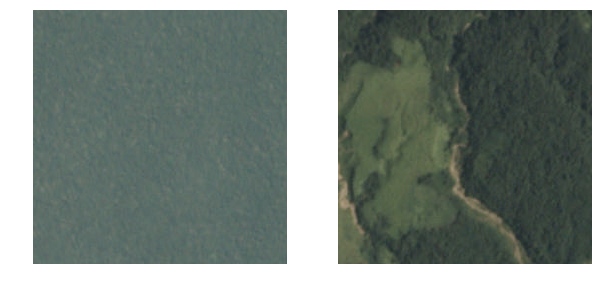

In [5]:
list_paths = [f'{PATH}/train-jpg/train_0.jpg', f'{PATH}/train-jpg/train_1.jpg']
plots_from_files(list_paths)

In [6]:
from planet import f2

metrics=[f2]
f_model = resnet34

In [7]:
label_csv = f'{PATH}/train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [8]:
def getData(sz,bs,arch,val = None):
    tfms = tfms_from_model(arch,sz=sz,aug_tfms=transforms_top_down,max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms, 
                                        suffix = '.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [9]:
data = getData(256,64,f_model)

In [10]:
x,y = next(iter(data.val_dl)) #val_dl grabs a mini batch while val_ds grabs a single image

In [11]:
y


    1     0     0  ...      0     0     1
    1     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
       ...          ⋱          ...       
    0     0     0  ...      0     0     1
    1     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
[torch.cuda.FloatTensor of size 64x17 (GPU 0)]

64 is the batch size and 17 is the number of classes

In [12]:
x


( 0 , 0 ,.,.) = 
 -1.2959 -1.2274 -1.1418  ...  -1.3130 -1.2103 -1.0904
 -1.2445 -1.2103 -1.1418  ...  -1.3987 -1.3644 -1.2788
 -1.1932 -1.1760 -1.1418  ...  -1.3987 -1.4500 -1.4329
           ...             ⋱             ...          
 -0.5253 -0.4739 -0.4054  ...  -0.8335 -0.6965 -0.5767
 -0.5596 -0.4911 -0.4054  ...  -0.7137 -0.5767 -0.4739
 -0.5767 -0.4911 -0.4054  ...  -0.6281 -0.5082 -0.4054

( 0 , 1 ,.,.) = 
 -0.9503 -0.9153 -0.8452  ...  -1.0728 -1.0028 -0.8978
 -0.9328 -0.8978 -0.8452  ...  -1.1253 -1.0728 -0.9678
 -0.9153 -0.8803 -0.8452  ...  -1.1604 -1.1253 -1.0553
           ...             ⋱             ...          
 -0.3025 -0.2675 -0.2150  ...  -0.4951 -0.4076 -0.3375
 -0.3200 -0.2850 -0.2325  ...  -0.4251 -0.3375 -0.2675
 -0.3375 -0.3025 -0.2325  ...  -0.4076 -0.3200 -0.2500

( 0 , 2 ,.,.) = 
 -0.8284 -0.8110 -0.7587  ...  -0.9504 -0.8633 -0.7587
 -0.7936 -0.7761 -0.7587  ...  -0.9853 -0.9504 -0.8807
 -0.7413 -0.7413 -0.7413  ...  -0.9678 -0.9853 -0.9504
           

In [13]:
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

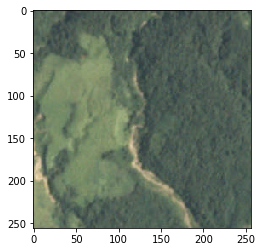

In [14]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4)

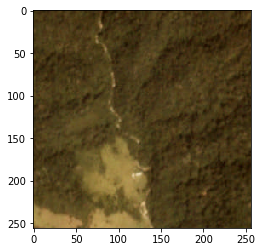

In [20]:
plt.imshow(data.val_ds.denorm(to_np(x))[1]*1.4)

In [11]:
sz=64

In [12]:
data = data.resize(int(sz*1.3), 'tmp') #This is to resize all images so that the processing is faster

In [13]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

epoch      trn_loss   val_loss   f2                          
    0      0.207021   0.29051    0.793839  



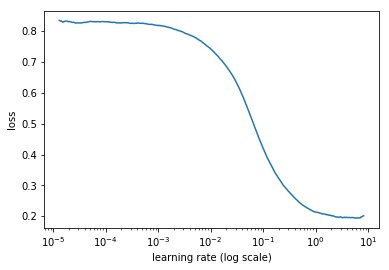

In [24]:
lrf=learn.lr_find()
learn.sched.plot()

In [14]:
lr= 0.2

In [26]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.139549   0.125264   0.894501  
    1      0.133219   0.120008   0.898114                    
    2      0.132662   0.118563   0.900392                    
    3      0.133881   0.118459   0.898914                    
    4      0.129647   0.11687    0.901607                    
    5      0.12631    0.115516   0.902629                    
    6      0.122283   0.115272   0.904061                    



[array([0.11527]), 0.9040608856534508]

In [15]:
lrs = np.array([lr/9,lr/3,lr])

In [28]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.116149   0.101811   0.915513  
    1      0.107959   0.097372   0.919228                    
    2      0.101281   0.093532   0.922583                     
    3      0.10661    0.096289   0.920407                    
    4      0.102057   0.093702   0.920692                     
    5      0.097513   0.090507   0.925003                     
    6      0.096229   0.089764   0.925738                     



[array([0.08976]), 0.92573839397421]

In [29]:
learn.save(f'{sz}')

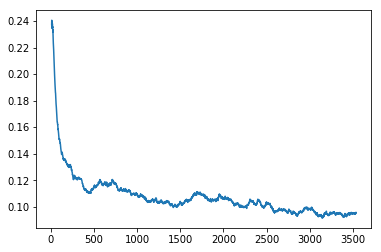

In [30]:
learn.sched.plot_loss()

In [34]:
learn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

In [36]:
sz = 128
learn.set_data(getData(sz,64,f_model))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.111208   0.105955   0.912599  
    1      0.114058   0.103842   0.913666                    
    2      0.110217   0.103056   0.914865                    
    3      0.108671   0.102938   0.914386                    
    4      0.10803    0.1018     0.914929                    
    5      0.106266   0.101439   0.915718                    
    6      0.108452   0.101383   0.915756                    



[array([0.10138]), 0.9157560498694836]

In [38]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

epoch      trn_loss   val_loss   f2                           
    0      0.097782   0.090216   0.926522  
    1      0.096633   0.090072   0.924805                     
    2      0.092358   0.086778   0.927633                     
    3      0.094494   0.089109   0.92671                      
    4      0.090754   0.087242   0.927439                     
    5      0.087571   0.085592   0.929619                     
    6      0.085153   0.08538    0.929258                     



In [16]:
learn.load(f'128')

In [20]:
sz = 256
learn.set_data(getData(sz,64,f_model))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                           
    0      0.091064   0.087628   0.926297  
    1      0.089194   0.087131   0.926606                     
    2      0.08901    0.085767   0.928049                     
    3      0.088403   0.085851   0.928302                     
    4      0.087927   0.085996   0.927613                     
    5      0.085384   0.085292   0.928433                     
    6      0.088231   0.08541    0.928243                     



[array([0.08541]), 0.9282429019468218]

In [21]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

epoch      trn_loss   val_loss   f2                           
    0      0.085273   0.082296   0.931714  
    1      0.08737    0.082561   0.930899                     
    2      0.082626   0.081441   0.931675                     
    3      0.087493   0.084765   0.928421                     
    4      0.08121    0.0827     0.932174                     
    5      0.081076   0.081219   0.93352                      
    6      0.079154   0.081211   0.933553                     



In [16]:
learn.load(f'256')

In [20]:
prob_preds, y= learn.TTA(is_test=True)

In [21]:
prob_preds.shape

(5, 40669, 17)

In [22]:
probs_tta = np.mean(np.exp(prob_preds), 0)
probs_tta.shape

(40669, 17)

In [62]:
data.test_ds.fnames

['test_25202',
 'test_5717',
 'test_40598',
 'test_35442',
 'test_22859',
 'test_13670',
 'test_3503',
 'test_34533',
 'test_22003',
 'test_18026',
 'test_10689',
 'test_3334',
 'test_20458',
 'test_28271',
 'test_37800',
 'test_21093',
 'test_38857',
 'test_40095',
 'test_29567',
 'test_15236',
 'test_19257',
 'test_36741',
 'test_16020',
 'test_39014',
 'test_29186',
 'test_20556',
 'test_38969',
 'test_5955',
 'test_17037',
 'test_3358',
 'test_13447',
 'test_10563',
 'test_9982',
 'test_40355',
 'test_19037',
 'test_5951',
 'test_1573',
 'test_4387',
 'test_27790',
 'test_36118',
 'test_37019',
 'test_25859',
 'test_12887',
 'test_16666',
 'test_18953',
 'test_38921',
 'test_26074',
 'test_1382',
 'test_29121',
 'test_26990',
 'test_24921',
 'test_12314',
 'test_21166',
 'test_18832',
 'test_11611',
 'test_35779',
 'test_8424',
 'test_39867',
 'test_35046',
 'test_449',
 'test_7030',
 'test_15939',
 'test_36274',
 'test_9214',
 'test_25619',
 'test_19986',
 'test_35836',
 'test_142

In [72]:
classes = np.array(data.classes, dtype=str)
res = [" ".join(classes[np.where(pp > 0.2)]) for pp in prob_preds[0]]

In [74]:
submission = pd.DataFrame(data=res)
submission.columns = ["tags"]

submission.insert(0, 'image_name', test_fnames)

In [75]:
submission

,image_name,tags
0,test_25202,agriculture cultivation partly_cloudy primary
1,test_5717,agriculture clear cultivation habitation haze ...
2,test_40598,agriculture clear partly_cloudy primary road w...
3,test_35442,agriculture clear primary water
4,test_22859,cloudy
5,test_13670,cloudy haze primary
6,test_3503,clear primary
7,test_34533,agriculture clear cultivation habitation partl...
8,test_22003,partly_cloudy primary
9,test_18026,clear cloudy water


In [76]:
submission.to_csv('submission_planet', index=False, index_label=None)